In [1]:
! pip install torch torchvision
! pip install torchsummary

In [2]:
import pathlib
import torch
from torch import optim
import torchvision.models as models
from torch.utils.data import Dataset
from torchvision import transforms, models
import matplotlib.pyplot as plt

torch.manual_seed(17)

# HYPERPARAMS

In [3]:
DEBUG = True
NUM_INPUT_CHANNELS = 3
NUM_OUTPUT_CHANNELS = 1

NUM_EPOCHS = 20

LR = 1e-6
MOMENTUM = 0.9
BATCH_SIZE = 16

# DATA PREPARATION

In [4]:
import json

class Image:
    def __init__(self, image_id, filename):
        self.filename = filename
        self.image_id = image_id
        self.captions = list()
            
    def add_caption(self, caption):
        self.captions.append(caption)
    
    def __repr__(self):
        return f"({self.filename}, {self.image_id}, {self.captions})"
            
class COCO:            
    def __init__(self, annotation_path):
        captions_train = json.load(pathlib.Path(annotation_path).open())
        self.data = list(self.create_index(captions_train).values())
        
    
    def create_index(self, captions):
        train_index = dict()
        for image in captions['images']:
            train_index[image['id']] = Image(image['id'], image['file_name'])
        
        for caption in captions['annotations']:
            train_index[caption['image_id']].add_caption(caption['caption'])
        return train_index    
        
        

In [5]:
TRAIN_ANNOTATION = '/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json'
TRAIN_IMAGE = '/kaggle/input/coco-2017-dataset/coco2017/train2017'

VAL_ANNOTATION = '/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_val2017.json'
VAL_IMAGE = '/kaggle/input/coco-2017-dataset/coco2017/val2017'

In [6]:
from torchvision.io import read_image

class CocoDataset(Dataset):
    def __init__(self, annotation_path, image_path):
        self.annotation_path = annotation_path
        self.image_path = image_path
        self.coco = COCO(annotation_path)
    
    def __len__(self):
        return len(self.coco.data)
    
    def __getitem__(self, idx):
        image_data = self.coco.data[idx]
        image_path = pathlib.Path(self.image_path) / image_data.filename
        image = read_image(str(image_path))
#         mask = read_image(mask_path).double()
#         transform_common = transforms.Compose([
#             SquarePad(),
#             transforms.Resize(IMG_SIZE),
#         ])
#         #todo: augmentation
#         image = transform_common(image)
#         mask = torch.mean(transform_common(mask), 0)
#         mask = torch.where(mask == 0, mask, 1).float()
        return image, image_data.captions

In [7]:
dataset = CocoDataset(TRAIN_ANNOTATION, TRAIN_IMAGE)

['A woman wearing a net on her head cutting a cake. ',
 'A woman cutting a large white sheet cake.',
 'A woman wearing a hair net cutting a large sheet cake.',
 'there is a woman that is cutting a white cake',
 "A woman marking a cake with the back of a chef's knife. "]

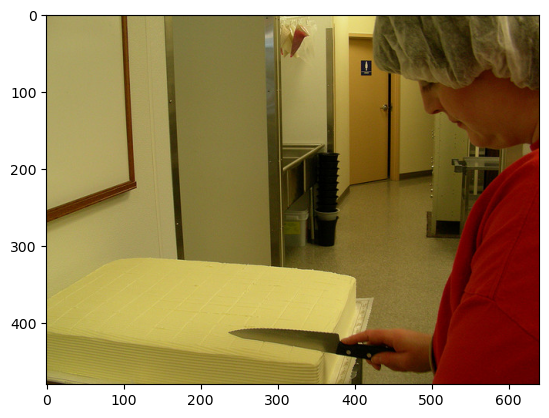

In [8]:
plt.imshow(dataset[1][0].int().permute(1,2,0))
dataset[1][1]

# CONSTRUCT MODEL